## Convolutional Neural Networks with PyTorch

This lab revolves around the creation of a convolutional neural network, to explore the principal techniques behind this interesting concept. To do so, we will create 2 generated datasets composed of 1 channel images (black and white images), to classify horizontal and vertical bars (some variation is introduced in the pixels of the images using a Bernoulli Distribution). The first one is a training dataset, gathering 10 000 images to train the neural network model (which has convolutional layers, max pooling, fully connected and linear layers), and a validation dataset with 1 000 images, to eventually test the accuracy of the trained model.

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.distributions.bernoulli import Bernoulli

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
class CreateDataset(Dataset):
  def __init__(self, N_images=100, offset=0, train = False):
    if train == True:
      torch.manual_seed(0)
    N_images = (N_images // 2) * 2
    images = torch.zeros((N_images,1,11,11), dtype=torch.float32)
    self.y = torch.zeros(N_images, dtype=torch.long)

    for i, image in enumerate(images):
      if i < N_images / 2:
        m = Bernoulli(torch.tensor([0.9]))
        image[0][4:7,1:10] = m.sample(sample_shape=[3,9]).reshape((3,9))
      else:
        m = Bernoulli(torch.tensor([0.9]))
        image[0][1:10,4:7] = m.sample(sample_shape=[9,3]).reshape((9,3))
        self.y[i] = 1

    self.x = images
    del images

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return len(self.x)


In [5]:
train_dataset = CreateDataset(N_images = 10000, train = True)

In [6]:
validation_dataset = CreateDataset(N_images = 1000)

In [7]:
train_dataset[0]

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
          [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
          [0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]), tensor(0))

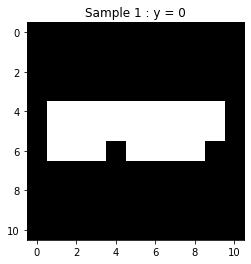

In [8]:
def show_data(dataset, sample):
  plt.imshow(dataset[sample][0][0], cmap='gray')
  plt.title(f"Sample {sample + 1} : y = {str(dataset[sample][1].item())}")
  plt.show()

show_data(train_dataset, 0)

In [9]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    # first convolutional layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=2) #10,10
    self.max1 = nn.MaxPool2d(kernel_size=2, stride=1) #9,9
    # second convolutional layers
    self.conv2 = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=2) #8,8
    self.max2 = nn.MaxPool2d(kernel_size=2, stride=1) # 7,7
    # fully connected layer
    self.fc1 = nn.Linear(1*7*7,2)

  def forward(self, x):
    z11 = self.conv1(x)
    a11 = torch.relu(z11)
    z12 = self.max1(a11)
    z21 = self.conv2(z12)
    a21 = torch.relu(z21)
    z22 = self.max2(a21)
    z = self.fc1(z22.reshape(z22.shape[0],-1))
    return z

  def forward_2(self, x):
    z11 = self.conv1(x)
    a11 = torch.relu(z11)
    z12 = self.max1(a11)
    z21 = self.conv2(z12)
    a21 = torch.relu(z21)
    z22 = self.max2(a21)
    return z22

### Define the Convolutional Neral Network Classifier , Criterion function, Optimizer and Train the  Model


In [53]:
model = CNN()

Let's try the forward propagation on the first record of the training dataset:

We see when we perform the full forward propagation that it gives us two linear outputs -> one for each category we want to classify (horizontal (0) and vertical (1) bars). The index of the greater value is the predicted category.

In [55]:
model(train_dataset[0][0].reshape((1,1,11,11)))

tensor([[-0.0425,  0.0314]], grad_fn=<AddmmBackward>)

We created a forward_2 method to see what are the effects of the convolutional and max pooling layers on the images, intermediary steps before the data goes to the fully connected, linear layers

In [56]:
z0 = model.forward_2(train_dataset[0][0].reshape((1,1,11,11)))
z0

tensor([[[[0.1855, 0.1774, 0.1774, 0.1774, 0.1774, 0.1774, 0.1774],
          [0.2011, 0.1774, 0.1774, 0.1774, 0.1774, 0.1774, 0.1774],
          [0.2011, 0.1584, 0.1584, 0.1584, 0.1584, 0.1584, 0.1584],
          [0.2110, 0.2236, 0.2743, 0.2743, 0.2617, 0.2110, 0.2110],
          [0.2110, 0.2236, 0.2743, 0.2743, 0.2617, 0.2110, 0.2110],
          [0.1891, 0.1891, 0.2216, 0.2317, 0.2317, 0.1891, 0.1958],
          [0.1152, 0.1156, 0.1156, 0.1152, 0.1152, 0.1152, 0.1156]]]],
       grad_fn=<MaxPool2DWithIndicesBackward>)

We see the image shrinks during the process, operations with the kernels imply a reduction of its dimension after convolution and max pooling steps.

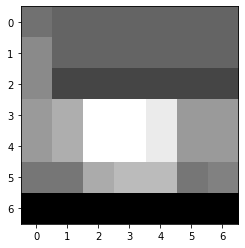

In [57]:
plt.imshow(z0.detach().numpy()[0][0], cmap="gray")
plt.show()

In [58]:
train_loader = DataLoader(dataset=train_dataset, batch_size=10)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=20)
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(params = model.parameters(), lr = lr)
epochs = 100

In [59]:
model

CNN(
  (conv1): Conv2d(1, 2, kernel_size=(2, 2), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(2, 1, kernel_size=(2, 2), stride=(1, 1))
  (max2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=49, out_features=2, bias=True)
)

In [60]:
cost_list = []
accuracy_list = []

for epoch in range(epochs):
  cost = 0
  for x, y in train_loader:
    optimizer.zero_grad()
    z = model(x)
    loss = criterion(z, y)
    loss.backward()
    optimizer.step()
    cost += loss.item()
  cost_list.append(cost)

  correct = 0
  for x_test, y_test in validation_loader:
    z = model(x_test)
    _, yhat = torch.max(z, 1)
    correct += (yhat == y_test).sum().item()
  accuracy = correct / len(validation_dataset)
  accuracy_list.append(accuracy)



Text(0.5, 0, 'Epoch')

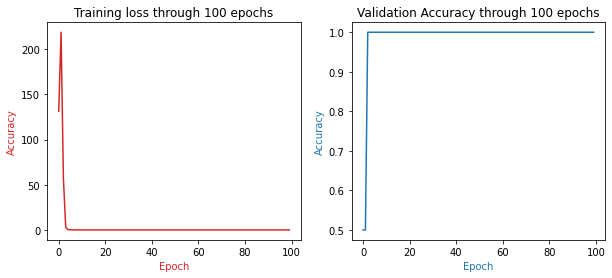

In [66]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
color = 'tab:red'
sns.lineplot(data=cost_list, ax = ax1, color = color)
ax1.set_title("Training loss through 100 epochs")
ax1.set_ylabel('Accuracy', color=color)
ax1.set_xlabel('Epoch', color=color)

color = 'tab:blue'
sns.lineplot(data=accuracy_list, ax = ax2, color=color)
ax2.set_title("Validation Accuracy through 100 epochs")
ax2.set_ylabel('Accuracy', color=color)
ax2.set_xlabel('Epoch', color=color)

Let's see what the forward propagation gives now the model is trained:

In [67]:
model(train_dataset[0][0].reshape((1,1,11,11)))

tensor([[  3.8287, -28.6731]], grad_fn=<AddmmBackward>)

The prediction is way clearer now, there's no doubt the first image of the training dataset is a horizontal bar!

In [75]:
z0 = model.forward_2(train_dataset[0][0].reshape((1,1,11,11)))
z0

tensor([[[[3.0375, 3.0107, 3.0107, 3.0107, 3.0107, 3.0107, 3.0107],
          [6.2494, 6.2184, 6.2184, 6.2184, 6.2184, 6.2184, 6.2184],
          [7.1095, 7.1363, 7.1631, 7.1631, 7.1363, 7.1095, 7.1095],
          [7.1095, 7.1363, 7.1631, 7.1672, 7.1672, 7.1095, 7.1095],
          [7.1095, 7.1095, 6.7899, 7.1672, 7.1672, 7.1095, 7.1095],
          [4.0674, 4.0674, 3.6808, 4.0984, 4.0984, 4.0674, 4.0674],
          [0.8884, 0.8884, 0.7484, 0.8884, 0.8884, 0.8884, 0.8884]]]],
       grad_fn=<MaxPool2DWithIndicesBackward>)

We can show the image and it confirms the idea. All the white pixels stand for the higher values in the multidimensional tensor.

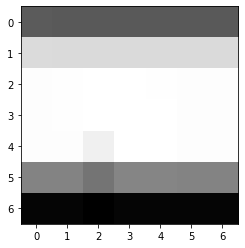

In [69]:
plt.imshow(z0.detach().numpy()[0][0], cmap="gray")
plt.show()